In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [59]:
data_dir = '/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Faces'

img_height, img_width = 200, 200
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=4
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=4
)

Found 1067 images belonging to 30 classes.
Found 252 images belonging to 30 classes.


In [60]:
train_generator.class_indices

{'ajay_devgn': 0,
 'akshay_kumar': 1,
 'amitabh_bachchan': 2,
 'anil_kapoor': 3,
 'anushka_shetty': 4,
 'deepika_padukone': 5,
 'farida_jalal': 6,
 'hrithik_roshan': 7,
 'huma_qureshi': 8,
 'irrfan_khan': 9,
 'kajol': 10,
 'kalki_koechlin': 11,
 'kamal_haasan': 12,
 'kangana_ranaut': 13,
 'madhavan': 14,
 'mohanlal': 15,
 'naseeruddin_shah': 16,
 'priyanka_chopra': 17,
 'radhika_apte': 18,
 'rajinikanth': 19,
 'ramya_krishnan': 20,
 'ranbir_kapoor': 21,
 'rani_mukerji': 22,
 'rekha': 23,
 'rishi_kapoor': 24,
 'saif_ali_khan': 25,
 'shah_rukh_khan': 26,
 'sridevi': 27,
 'tabu': 28,
 'vidya_balan': 29}

In [5]:
classes = list(train_generator.class_indices.keys())
classes

['ajay_devgn',
 'akshay_kumar',
 'amitabh_bachchan',
 'anil_kapoor',
 'anushka_shetty',
 'deepika_padukone',
 'farida_jalal',
 'hrithik_roshan',
 'huma_qureshi',
 'irrfan_khan',
 'kajol',
 'kalki_koechlin',
 'kamal_haasan',
 'kangana_ranaut',
 'madhavan',
 'mohanlal',
 'naseeruddin_shah',
 'priyanka_chopra',
 'radhika_apte',
 'rajinikanth',
 'ramya_krishnan',
 'ranbir_kapoor',
 'rani_mukerji',
 'rekha',
 'rishi_kapoor',
 'saif_ali_khan',
 'shah_rukh_khan',
 'sridevi',
 'tabu',
 'vidya_balan']

In [6]:
pd.Series(train_generator.classes).value_counts()

,count
28,40
16,40
14,40
11,39
1,39
12,39
29,38
21,38
9,38
18,37


# Build CNN model

In [7]:
def create_models(num_classes, input_shape=(200, 200, 3), embedding_dim=128):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2, strides=2)(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2, strides=2)(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    # Dropout to prevent overfitting
    x = layers.Dropout(0.5)(x)

    # Embedding layer
    embedding = layers.Dense(embedding_dim, name='embedding')(x)

    # Classification layer
    outputs = layers.Dense(num_classes, activation='softmax')(embedding)

    # Create models
    full_model = models.Model(inputs=inputs, outputs=outputs, name='face_shape_classifier')
    embedding_model = models.Model(inputs=inputs, outputs=embedding, name='face_shape_embedding')

    return full_model, embedding_model

In [8]:
num_classes = len(train_generator.class_indices)

classifier_model, embedding_model = create_models(num_classes=num_classes)

classifier_model.summary()
classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "face_shape_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 425,182 (1.62 MB)

 Trainable params: 425,182 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = classifier_model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=validation_generator,
    # validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/34 ━━━━━━━━━━━━━━━━━━━━ 5:55 15s/step - accuracy: 0.0233 - loss: 3.4168

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = classifier_model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.4888 - loss: 2.9570
Validation Loss: 3.0106
Validation Accuracy: 0.4494


In [ ]:
# Get predictions on the validation set
validation_generator.reset()
y_pred = classifier_model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step


In [ ]:
# Generate classification report
class_names = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       heart       0.27      0.22      0.24        82
      oblong       0.30      0.37      0.33        91
       round       0.25      0.24      0.25        82
      square       0.26      0.25      0.25        81

    accuracy                           0.27       336
   macro avg       0.27      0.27      0.27       336
weighted avg       0.27      0.27      0.27       336



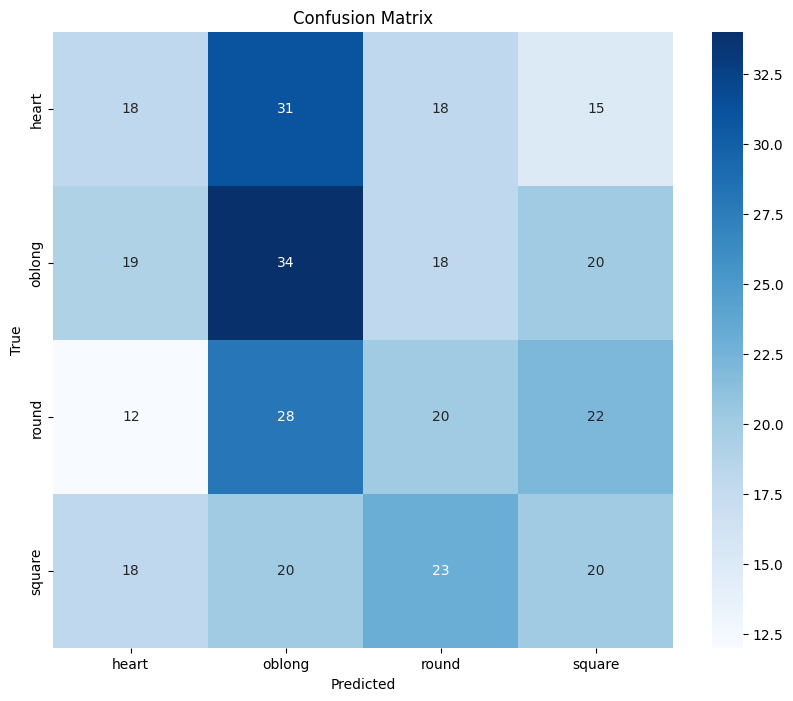

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

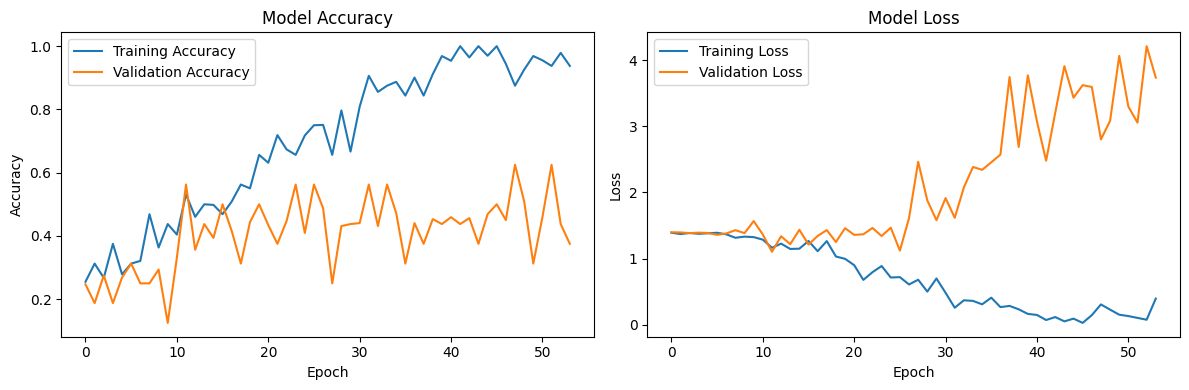

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
classes = list(train_generator.class_indices.keys())

def predict_face(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.
    predicts = classifier_model.predict(img_array)
    predicted_class = classes[np.argmax(predicts)]
    return predicted_class

In [ ]:
predict_face('/content/drive/MyDrive/Dataset/Face Shape Dataset/test/heart (777).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


'square'

# ResNet Model

In [93]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import matplotlib.pyplot as plt
import os

In [94]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

In [95]:
def create_fine_tuned_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [96]:
data_dir = '/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Faces'

In [97]:
# def fine_tune_model(data_dir):
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=4
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=4
)

# return model, train_generator.class_indices, history, train_generator

Found 1067 images belonging to 30 classes.
Found 252 images belonging to 30 classes.


In [98]:
num_classes = len(train_generator.class_indices)
model = create_fine_tuned_model(num_classes)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=12,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 242s 7s/step - accuracy: 0.0836 - loss: 4.0367 - val_accuracy: 0.1562 - val_loss: 2.9359
Epoch 2/50
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2:26 5s/step - accuracy: 0.2188 - loss: 2.8621

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2188 - loss: 2.8621 - val_accuracy: 0.1786 - val_loss: 2.9541
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 228s 7s/step - accuracy: 0.2363 - loss: 2.6802 - val_accuracy: 0.2545 - val_loss: 2.5180
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.3438 - loss: 2.3075 - val_accuracy: 0.2500 - val_loss: 2.3233
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 253s 7s/step - accuracy: 0.3497 - loss: 2.2482 - val_accuracy: 0.2768 - val_loss: 2.4380
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.3636 - loss: 2.6844 - val_accuracy: 0.2857 - val_loss: 2.2069
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 255s 7s/step - accuracy: 0.4119 - loss: 2.0523 - val_accuracy: 0.2812 - val_loss: 2.3050
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.4375 - loss: 1.9972 - val_accuracy: 0.3214 - val_loss: 1.8792
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 229s 7s/step - accuracy: 0.4658 - loss: 1.8114 - val_accuracy: 0.3125 - val_loss: 

In [99]:
# data_dir = '/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Faces'

# fine_tuned_model, class_indices, history, train_generator = fine_tune_model(data_dir)

In [106]:
fine_tuned_model = model
class_indices = train_generator.class_indices

In [72]:
fine_tuned_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 29,974,492 (114.34 MB)

 Trainable params: 2,128,926 (8.12 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,257,854 (16.24 MB)

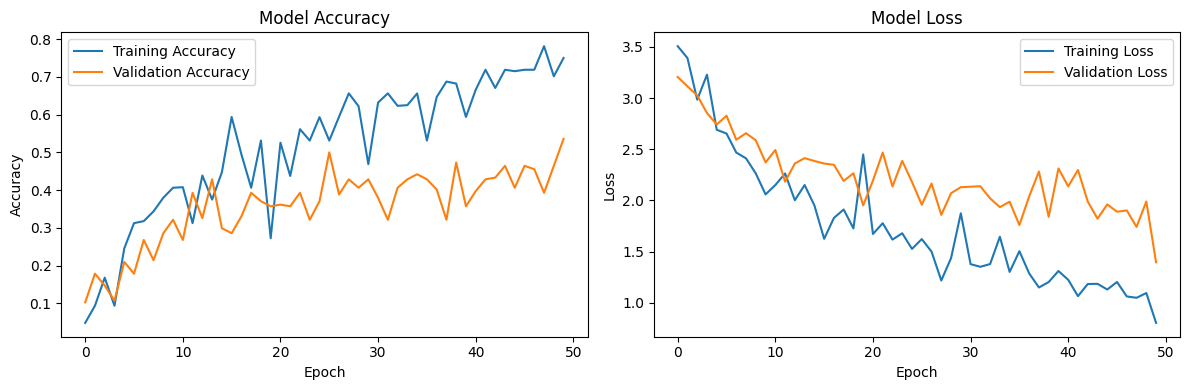

In [73]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [101]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = fine_tuned_model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.4518 - loss: 2.1595
Validation Loss: 2.1163
Validation Accuracy: 0.4603


In [102]:
# Get predictions on the validation set
validation_generator.reset()
y_pred = fine_tuned_model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step


In [103]:
# Generate classification report
class_names = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:")
print(report)


Classification Report:
                  precision    recall  f1-score   support

      ajay_devgn       0.00      0.00      0.00         8
    akshay_kumar       0.00      0.00      0.00         9
amitabh_bachchan       0.00      0.00      0.00         8
     anil_kapoor       0.00      0.00      0.00         7
  anushka_shetty       0.00      0.00      0.00         7
deepika_padukone       0.33      0.12      0.18         8
    farida_jalal       0.00      0.00      0.00         7
  hrithik_roshan       0.00      0.00      0.00         9
    huma_qureshi       0.00      0.00      0.00         9
     irrfan_khan       0.17      0.11      0.13         9
           kajol       0.00      0.00      0.00         8
  kalki_koechlin       0.00      0.00      0.00         9
    kamal_haasan       0.00      0.00      0.00         9
  kangana_ranaut       0.00      0.00      0.00         9
        madhavan       0.05      0.10      0.07        10
        mohanlal       0.00      0.00      0.00

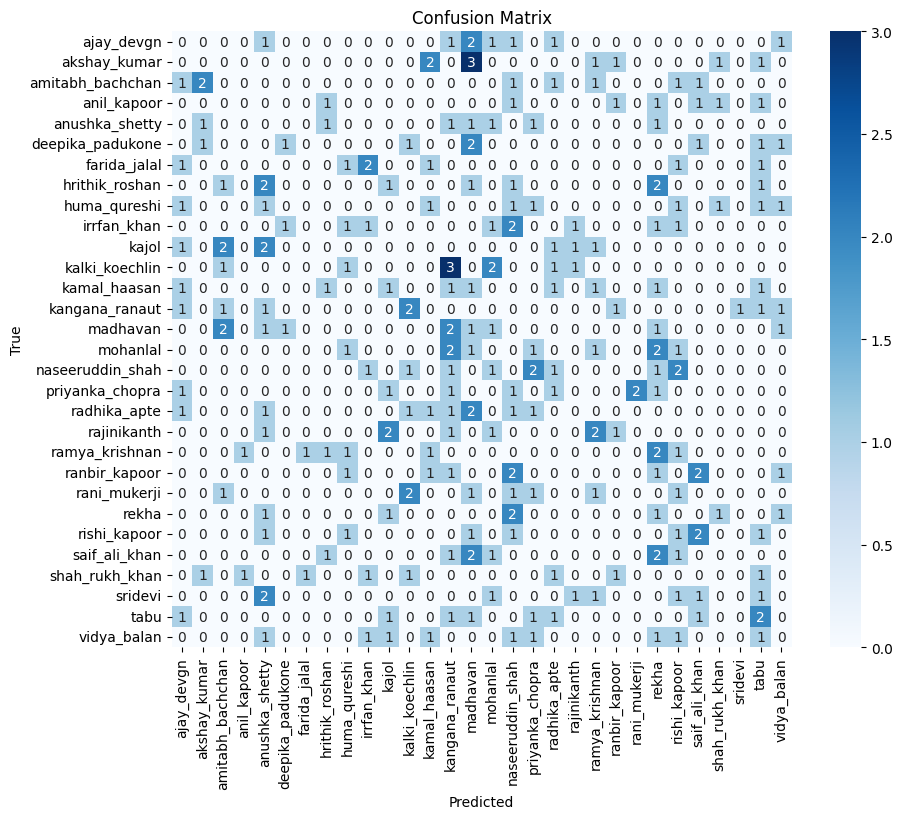

In [104]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [74]:
classes = list(train_generator.class_indices.keys())

def predict_celeb_face(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.

    predicts = fine_tuned_model.predict(img_array)

    top_5_indices = np.argsort(predicts[0])[::-1][:5]
    top_5_classes = [classes[i] for i in top_5_indices]
    top_5_probs = [predicts[0][i] for i in top_5_indices]

    return list(zip(top_5_classes, top_5_probs))

In [107]:
input_image_path = "/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Faces/ajay_devgn/036d02cf72.jpg"
predict_celeb_face(input_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


[('rishi_kapoor', 0.26503214),
 ('kalki_koechlin', 0.14023648),
 ('radhika_apte', 0.07723484),
 ('rani_mukerji', 0.04959907),
 ('naseeruddin_shah', 0.049457014)]

In [108]:
# Save the models
fine_tuned_model.save('celeb_face_resnet_model.h5')

print("Models saved successfully.")

Models saved successfully.


In [109]:
def extract_features(model, data_dir):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    features = model.predict(generator)

    if len(features.shape) > 2:
        features = features.reshape(features.shape[0], -1)

    return features, generator.classes, generator.class_indices

In [110]:
features, labels, _ = extract_features(fine_tuned_model, data_dir)

Found 1319 images belonging to 30 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step


In [111]:
def save_embeddings(features, labels, class_indices, file_path='fine_tuned_embeddings.pickle'):
    data = {
        'features': features,
        'labels': labels,
        'class_indices': class_indices
    }

    with open(file_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [118]:
save_embeddings(features, labels, class_indices)

In [81]:
def load_embeddings(file_path='image_embeddings.pickle'):
    with open(file_path, 'rb') as handle:
        data = pickle.load(handle)
    return data['features'], data['labels'], data['class_indices']

In [113]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

In [114]:
def calculate_similarity(feature_vector, celebrity_features):
    feature_vector = feature_vector.reshape(1, -1)
    similarity_scores = cosine_similarity(feature_vector, celebrity_features)
    return similarity_scores

In [115]:
def get_top_n_similar_celebrities(similarity_scores, celebrity_names, n=5):
    top_n_indices = np.argsort(similarity_scores[0])[::-1][:n]
    top_n_celebrities = [celebrity_names[i] for i in top_n_indices]
    top_n_scores = [similarity_scores[0][i] for i in top_n_indices]
    return list(zip(top_n_celebrities, top_n_scores))

In [116]:
def find_celebrity_image(celebrity_name, data_dir):
    for root, dirs, files in os.walk(data_dir):
        if os.path.basename(root) == celebrity_name:
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    return os.path.join(root, file)
    return None

In [117]:
def find_and_visualize_similar_celebrities(input_image_path, data_dir, model, n=5):
    celebrity_features, labels, class_indices = load_embeddings()

    idx_to_class = {v: k for k, v in class_indices.items()}
    celebrity_names = [idx_to_class[np.argmax(label)] for label in labels]

    input_img = load_and_preprocess_image(input_image_path)
    input_features = model.predict(input_img)

    if len(input_features.shape) > 2:
        input_features = input_features.reshape(input_features.shape[0], -1)

    if len(celebrity_features.shape) > 2:
        celebrity_features = celebrity_features.reshape(celebrity_features.shape[0], -1)

    similarity_scores = calculate_similarity(input_features, celebrity_features)
    top_celebrities = get_top_n_similar_celebrities(similarity_scores, celebrity_names, n)

    plt.figure(figsize=(15, 8))
    plt.subplot(2, 3, 1)
    input_img = image.load_img(input_image_path)
    plt.imshow(input_img)
    plt.title("Input Image")
    plt.axis('off')

    for i, (celebrity, score) in enumerate(top_celebrities, start=2):
        plt.subplot(2, 3, i)
        celebrity_img_path = find_celebrity_image(celebrity, data_dir)
        if celebrity_img_path:
            img = image.load_img(celebrity_img_path)
            plt.imshow(img)
            plt.title(f"{celebrity}\nScore: {score:.4f}")
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, f"Image not found\n{celebrity}\nScore: {score:.4f}",
                     ha='center', va='center')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    return top_celebrities

In [87]:
input_image_path = "/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Faces/ajay_devgn/036d02cf72.jpg"
data_dir = '/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Faces'
top_5_celebrities = find_and_visualize_similar_celebrities(input_image_path, data_dir, fine_tuned_model)

print("Top 5 similar celebrities:")
for celebrity, score in top_5_celebrities:
    print(f"{celebrity}: Similarity score = {score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 30 while Y.shape[1] == 2048

# Crop face from image

In [ ]:
import dlib
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

In [ ]:
def detect_faces(image):
    face_detector = dlib.get_frontal_face_detector()

    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

In [ ]:
def crop_faces_with_padding(image, face_rects, padding=20):
    cropped_faces = []
    for face_rect in face_rects:
        left, top, right, bottom = face_rect

        left = max(0, left - padding)
        top = max(0, top - padding - 10)
        right = min(image.shape[1], right + padding)
        bottom = min(image.shape[0], bottom + padding)

        face = Image.fromarray(image).crop((left, top, right, bottom))
        cropped_faces.append(face)

    return cropped_faces

In [ ]:
img_path = '/content/download (4).jpeg'
image = io.imread(img_path)

detected_faces = detect_faces(image)
cropped_faces = crop_faces_with_padding(image, detected_faces)

# Save cropped faces
for n, face in enumerate(cropped_faces):
    face.save(img_path + '_cropped_face.jpg', 'JPEG')

In [ ]:
# Plot the cropped faces
for n, face in enumerate(cropped_faces):
    plt.subplot(1, len(cropped_faces), n + 1)
    plt.axis('off')
    plt.imshow(face)

plt.show()

In [ ]:
top_5_celebrities = find_similar_celebrities('/content/download (4).jpeg_cropped_face.jpg', resnet_model)

print("Top 5 similar celebrities:")
for celebrity, score in top_5_celebrities:
    print(f"{celebrity}: Similarity score = {score:.4f}")